## Jigsaw Multilingual Toxic Comment Classification
It only takes one toxic comment to sour an online discussion. The Conversation AI team, a research initiative founded by Jigsaw and Google, builds technology to protect voices in conversation. A main area of focus is machine learning models that can identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion. If these toxic contributions can be identified, we could have a safer, more collaborative internet.

In the previous 2018 Toxic Comment Classification Challenge, Kagglers built multi-headed models to recognize toxicity and several subtypes of toxicity. In 2019, in the Unintended Bias in Toxicity Classification Challenge, you worked to build toxicity models that operate fairly across a diverse range of conversations. This year, we're taking advantage of Kaggle's new TPU support and challenging you to build multilingual models with English-only training data.

Jigsaw's API, Perspective, serves toxicity models and others in a growing set of languages (see our documentation for the full list). Over the past year, the field has seen impressive multilingual capabilities from the latest model innovations, including few- and zero-shot learning. We're excited to learn whether these results "translate" (pun intended!) to toxicity classification. Your training data will be the English data provided for our previous two competitions and your test data will be Wikipedia talk page comments in several different languages.

As our computing resources and modeling capabilities grow, so does our potential to support healthy conversations across the globe. Develop strategies to build effective multilingual models and you'll help Conversation AI and the entire industry realize that potential.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


# EDA

In [7]:
import pandas as pd
#loading data
train_data = pd.read_csv("data/jigsaw-toxic-comment-train.csv")
validation_data = pd.read_csv("data/validation.csv")
test_data = pd.read_csv("data/test.csv")

In [8]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [9]:
validation_data.head()

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [10]:
test_data.head()

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [14]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install plotly


  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11434 sha256=078f7a43fc7f00849872aaed4f55c8e32571ab96f32a543ab18822f1ecdcfe7d
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\c4\a7\48\0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying



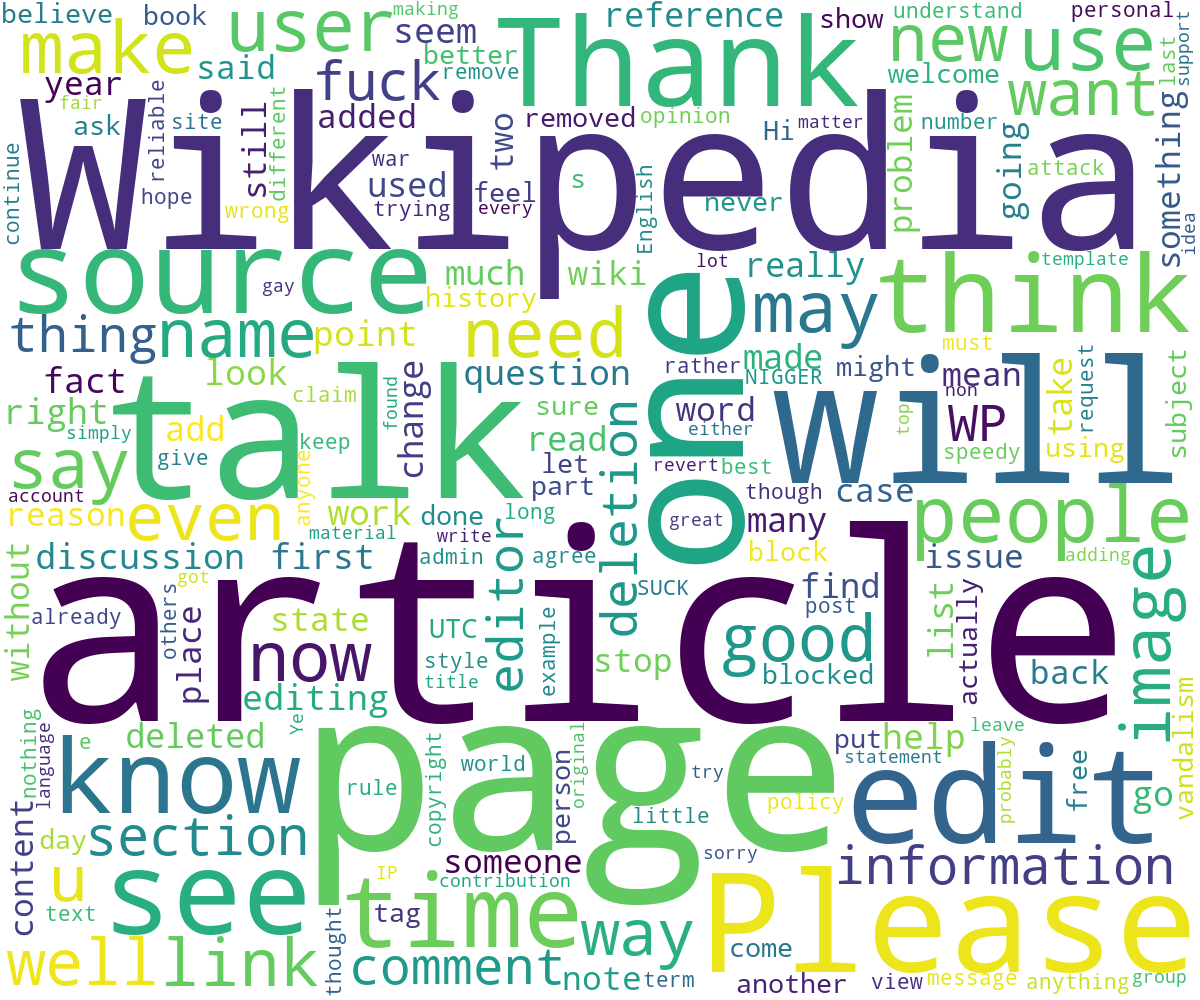

In [21]:
from wordcloud import WordCloud
import plotly.express as px
def nonan(x):
    if type(x) == str:
        return x.replace("\n", "")
    else:
        return ""

text = ' '.join([nonan(abstract) for abstract in train_data["comment_text"]])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
fig = px.imshow(wordcloud)
fig.update_layout(title_text='Common words in comments')


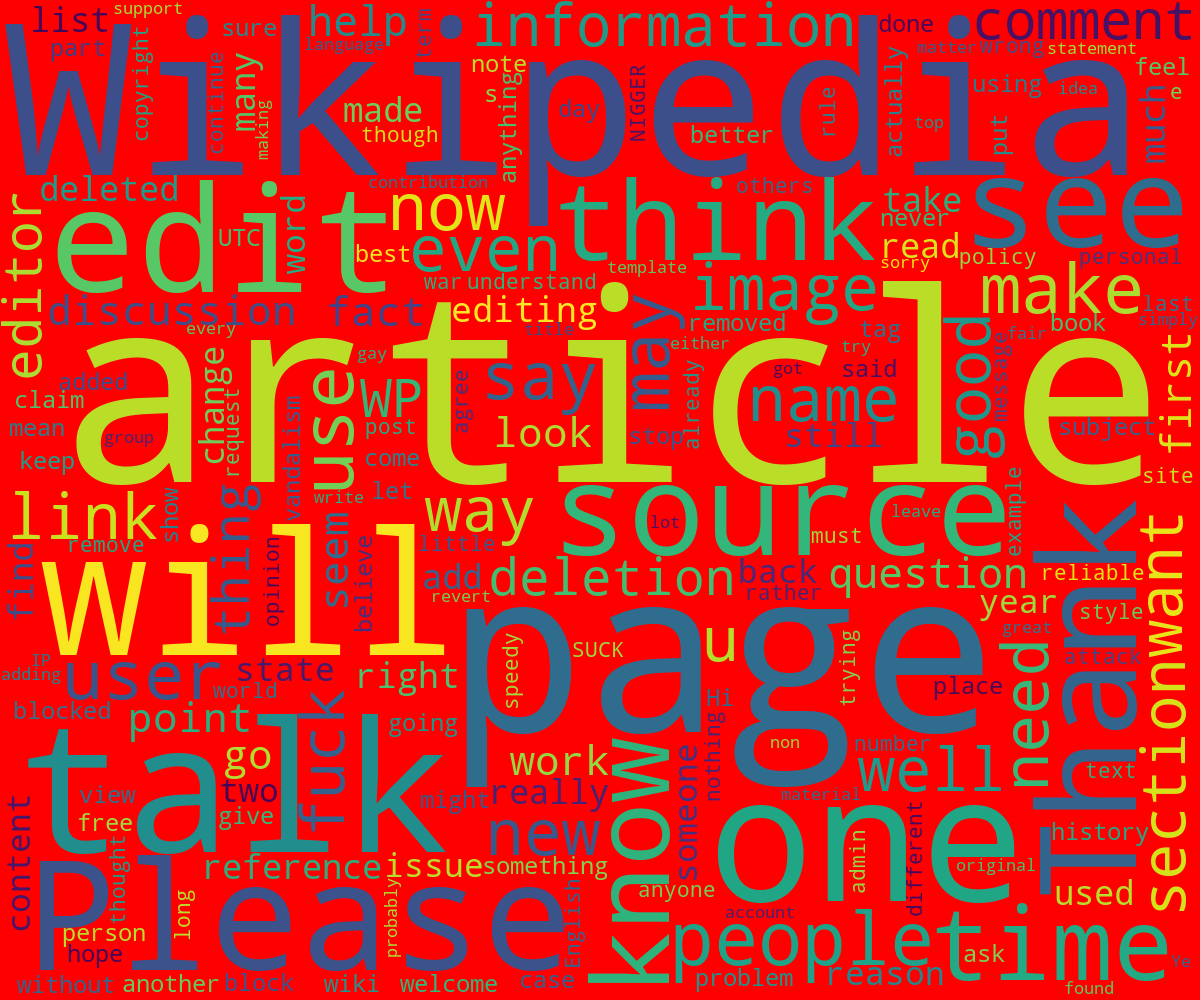

In [22]:
wordcloud = WordCloud(max_font_size=None, background_color='red', collocations=False,
                      width=1200, height=1000).generate(text)
fig = px.imshow(wordcloud)
fig.update_layout(title_text='Common words in comments')